# Data analysis with SciAnalysis

last updated: 2022-Sep-7

v1: SciAnalysis, result-viewing, ExpAnalysis 

v2: SciAnalysis, do all reviewing in ExpAnalysis

### Section A: SciAnalysis

- A1. <span style='background :yellow' > __Tutorial to SciAnalysis__</span> (stadard routines: circular_average, qr_image, etc): If you are not familiar with SciAnalysis, go through Section A1 carefully, this will help you understand the code and run the routine data reduction/analysis. 
- A2. Stitching SAXS or WAXS raw data
- A3. Background subtraction: 2D (To-do low priority): Stitching SAXS+WAXS in 1D
- A4. Adjust fitting: load DAT file and fit
- A5. Load XML: roi, fitting result
- A6. Load ROI: roi, fitting result


To-Do: put A5 and A6 input Experiment?


### Section B - Experiment: Viewing & Comparing Results

<span style='background :yellow' > NEW </span> feature! Define a series of measurement as one experiment, save all metadata, analysis results, plotting/comparison results into one H5 file. 

<span style='background :yellow' > Note </span> for developer: The experiment class is defined in __SciAnalysis/ExpAnalysis/Experiment.py__. 
(For easier debugging/developing, can use __ExpAnalysis_debug_v1.ipynb__)
    
- B1. Define Experiment Dictionary: Metadata, Analysis data
- B2. Plot 1D curves: waterfall, heatmap/2D 
- B3. Plot 2D images: NPZ, PNG 

To-Do: Save all output to H5 

To-Do: Plot 2D images within exp, stack PNG to TIFF (for viewing in imageJ)

To-Do: Other plottings


### Section C - Analysis for an experiment 

<span style='background :yellow' > Coming soon!</span> 

- C1. To-Do: Compare multiple experiments, e.g. fitting intensity changes


# &#9635; Section A: SciAnalysis

## &#9632; A1. Tutorial to SciAnalysis

Load raw data (TIFF) and do analysis

### A1.1 Download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis

### A1.2 Put your download path for SciAnalysis_PATH:

In [ ]:
%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols


### A1.3. Specify beamline parameters 

Specify parameters based on SAXS/WAXS and beamline configuration.

In [ ]:
# Experimental parameters
########################################
## CMS
if 1:
    # Custom Dectris Pilatus 800k (lower-left modules removed)
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(475, 1043-386) 

    calibration.set_distance(0.259)

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    mask = Mask(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png')

## SMI
if 0:
    calibration = Calibration(wavelength_A=0.770088) # 16.1 keV
    calibration.set_image_size(981, height=1043) 
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_distance(8.320) # 8.300 nominal detector distance

    ## With AgBH
    calibration.set_distance(8.300) # 8.300 nominal detector distance
    calibration.set_beam_position(492, 557) #2022 TSAXS, VS    ###Choose the one you need
    #calibration.set_beam_position(492, 557+145) #2022 GISAXS, HE   ###Choose the one you need

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus1M_main_gaps-mask.png')
    mask.load('./mask_badpixel3.png')

### A1.4. Specify data path and analysis parameters

Specify data directory (source_dir) and where you want to save the outputs (output_dir).

#### Use 'pattern' to specify the files you want to analyze. Can start with one specific file of interest to determine the analysis protocal and parameters (Sections A1.4 and A1.5), and then process all data.

Specify the analysis protocal to use, e.g.
- circular average integrate over the entire ring, and outputs Intensity vs. q in PNG and also in DAT
- sector_average(name = 'sector_average_angle60_d10', angle=60, dangle=10) outputs the integration over dangle 10deg, with center at angle 60 (twelve oclock is 0 degree, goes clock-wise, so 60deg is two olock direction). Outputs are stored under the folder 'sector_average_angle60_d10'. Changing the name can be useful if you want different sector_average analysis.
- See Readme in https://github.com/CFN-softbio/SciAnalysis


In [ ]:
# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'  ### CHANGE THIS
source_dir = EXPR_DIR + 'stitched/'   ### CHANGE THIS
output_dir = EXPR_DIR + 'stitched_analysis_test/'   ### CHANGE THIS

#patterns = ['*117709*' ]
patterns = ['*117840*','*117642*','*117644*','*117830*','*117832*'] ### CHANGE THIS


# Analysis to perform
########################################

load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : False,
             }
run_args = { 'verbosity' : 3,
            'fittype': 'voigt',
            }

run_args = { 'verbosity' : 3,
             'rcParams': {'axes.labelsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            'fittype': 'voigt',
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    #Protocols.calibration_check(show=False, AgBH=True, q0=0.1076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'
    
    Protocols.qr_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,
    #Protocols.thumbnails(name='thumbnails_vgehdr', crop=None, resize=0.5, cmap=cmap_vge_hdr, ztrim=[0.02, 0.001]) , # Pilatus800k

    Protocols.circular_average_q2I_fit(name='circular_fit_compare3', plot_range=[1.2, 1.8, -0.5, 2], qn_power=0.0, trim_range=[0.1, 3.5], fit_range=[1.4-0.04, 1.44+0.07], num_curves=1, q0=[1.415], sigma=0.02, gamma=0.02, show_curves=1, label_filename=True), 
   
    #Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.5, -90, +90],transparent=False),
    
    Protocols.roi(show_region=False, qx=1, dqx=0.05, qz=1, dqz=0.05, prepend='stats_')
     
    ]

### A1.5. Apply analysis 

- Run this step to do the analysis. Repeat Sections A1.4 and A1.5 to adjust protocoal parameters and apply analysis.

- If force=1, it will do analysis and overwrite old analysis results. 

- If the last line (process.monitor_loop) is used, it will run real-time analysis, ie, it keeps on checking if there are new files in the source_dir to apply the analysis protocals, force=0 in this case to process only new data.

In [ ]:
# Run
########################################
t0 = time.time()

for pattern in patterns:   
    infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
    infiles.sort()    
    
    print('Processing {} infiles...'.format(len(infiles)))
    process.run(infiles, protocols, output_dir=output_dir, force = 1) ### CHANGE THIS: force=0 or 1

print('===== Process Time: {:.1f} min ====='.format((time.time()-t0)/60))


########################################
# This is typically only used at the beamline (it loops forever, watching for new files).
#process.monitor_loop(source_dir=source_dir, pattern='*.tiff', protocols=protocols, output_dir=output_dir, force=False)



## &#9632;  A2. Stitching 2D SAXS or WAXS 
 
#### Option 1. Current standard at the beamline: using Jupyter Notebook by RL 

1) Run ./software/StitchPilatus/stitch_2M.ipynb or stitch_800l.ipynb, this will output TIFF under ./stitched/

2) Run analysis (Section A1) using the stitched TIFF files instead of the ./raw/ ones. Change mask.


#### Option 2. Stitch files with SciAnalysis:
 
 1) run stitch.py to stitch into .TIFF (This stitched TIFF is larger than what's done in Option 1.)
 
 2) run runStitched.py to generate thumbnails etc

 ## &#9632;  A.3 Background subtraction 
 
 Same as Section A1, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73
#calibration.set_beam_position(738.0, 1679-563 ) # 8--12
calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)

print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### Show before/after background subtraction

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)


 ## &#9632;  A.4 Adjust fitting
 
- Option 1. Can be done directly on raw data by specifying the propotcal in Section A1, 
- Option 2. Run the following section to load a 1D curve and apply fitting.

In [ ]:
## Load one DAT infile to test and select fitting range
pattern = ''
infiles = glob.glob(os.path.join(output_dir+'/circular_average/', pattern+'*.dat')); 
infile = infiles[0]
if 0:
    line = DataLine(infile) 
else:
    data = np.loadtxt(infile)
    line = DataLine(x = data[:,0], y = data[:,2])

    
## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}

protocol = Protocols.fit_peaks()
lines = protocol._fit(line, results, **run_args, q0=[1, 2], num_curves=2, fit_range=[0.95, 2.5])


## Plot
#%matplotlib tk
#lines._plot_main(**plot_args)

for nn, line in enumerate(lines.lines):
    if nn==0: 
        plt.plot(line.x, line.y, 'b:', linewidth=1, label=line.name)
        plt.title(line.name)
    else:
        plt.plot(line.x, line.y, 'g', linewidth=2, label=line.name)
        
    plt.grid()
    
    
    ## Plot reference lines
    xs = [0.7, 1.8]
    for x in xs:
        plt.axvline(x, color='r', dashes=[3,3])
        
    
    ## Plot range
    plt.xlim([0.4, 2.5])
    

        
plt.show()

#lines._plot_main()
#lines._plot_extra()

# from SciAnalysis.CurveAnalysis.Data import *
# line = DataLineStructuredSort(infile)
# lines = line.fit_peaks(line, num_curves=1, **run_args)


## &#9632;  A.5 Extract analysis results from .XML to .TXT and .NPY
 
 E.g. fitting parameters (output from runX.py) are saved in ./analysis/results/*.xml
 
 For one or multiple measurements, this script load the .XML and save it to .TXT and .NPY

In [34]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

Extracting results for 5 infiles...
  Extracted 5 results (failed on 0/5 = 0.0%)
Generated 5 results.
 Loading data from file: /nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/stitched_analysis_test/NT-extracted.txt

----- Output array:
 [[1.2661084715584041], [0.0013699127894982127], [0.0037535982592504405], [0.18602228189015912], [0.656085825226832]]


## &#9632;  A.6 Load ROI

Plotting 4 infiles...
                0  1             2
0              qx  :      1.000000
1             dqx  :      0.050000
2              qz  :      1.000000
3             dqz  :      0.050000
4       stats_max  :     84.000000
5       stats_min  :     21.000000
6   stats_average  :     40.431002
7       stats_std  :     14.914991
8         stats_N  :    529.000000
9     stats_total  :  21388.000000
10     stats_skew  :      1.162081
11   stats_spread  :     63.000000
12  stats_std_rel  :      0.368900


<IPython.core.display.Javascript object>


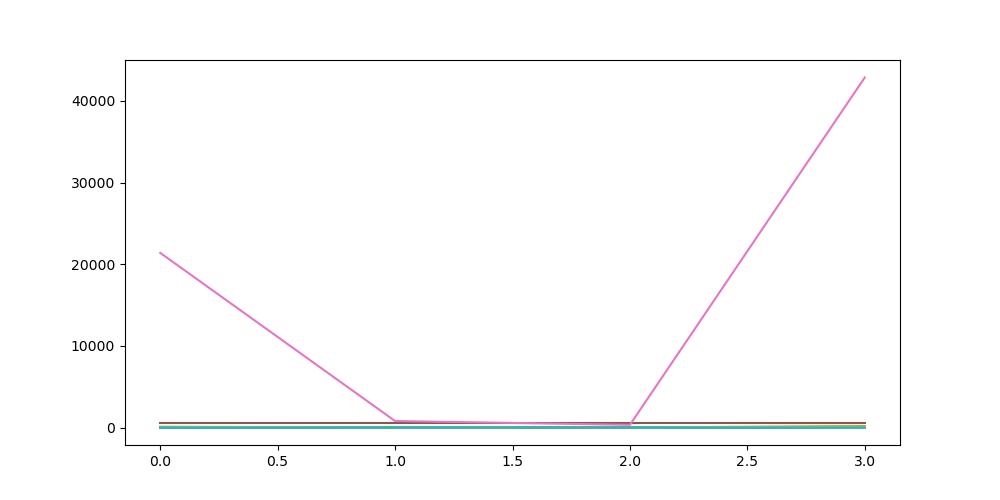

In [5]:
import pandas as pd

## Get infile
pattern = ''
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


# &#9635; Section B: Experiment: Viewing & Comparing Results

All analysis results are saved in the __output_dir__ you specified. You can view the results there directly. 

Alternatively, you can define an __experiment__ (series of measuremeants) and load/plot results here. This useful if you want to do comparison over many measurements, or to navigate the q positions on the plots etc. __The experiment class is defined in SciAnalysis/ExpAnalysis/Experiment.py__

In [25]:
%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis.ExpAnalysis.Experiment import *


## &#9632; B.1 Define Experiment (single/series of measurement)

Note: currently sample name has to be specified exactly, can use multiple sample names

In [106]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/SMorozova' ### CHANGE THIS

exp = experiment('CNC', folder=EXPR_DIR,det='saxs') ### CHANGE THIS
samples = ['SM_CNC_N21']  ### CHANGE THIS, Note that this have to match the sample name 

for sample in samples:
    exp.defFiles_query(fn=sample, folder=EXPR_DIR, scanid = [710000, 800000]) 
    
    

df599b61-f976-426e-b640-b8ee05effc3f
7982806d-b7b3-48e6-bdf6-8bf37a89cf40
ee30a4f5-4849-4531-8822-1a4ed0329e50
4b9657e6-dc9f-4187-9f28-42298ca626d8
8463f04b-7959-42c2-b84a-6a6f416ddff1
061dddab-5e40-4393-94dd-e3b31aa87393
de3d1c15-1aa3-4cc6-a2c9-9ac4a4a02276
7c7a890e-fb5f-46a5-8970-1bdc6172542b
2ff94512-0009-41f7-84cb-588430e9ab4a
Loaded 9 files, took 0.38542962074279785s.


#### Select metadata to load

In [107]:
## If you don't know the metadata you have/need
exp.listMetadata(verbosity=3)
exp.listMetadata(verbosity=-1) 

uid
time
experiment_user
experiment_cycle
experiment_group
experiment_project
beam_intensity_expected
experiment_proposal_number
experiment_SAF_number
experiment_alias_directory
calibration_energy_keV
scan_id
platform_beam
experiment_type
calibration_wavelength_A
plan_type
plan_name
detectors
num_points
num_intervals
plan_args
hints
sample_exposure_time
sample_measurement_ID
sample_holder_sample_number
sample_savename_extra
sample_name
sample_clock
sample_temperature
sample_temperature_A
sample_temperature_B
sample_temperature_C
sample_temperature_D
sample_x
sample_motor_x
sample_y
sample_motor_y
sample_th
sample_motor_th
sample_savename
detector_sequence_ID
beam_size_x_mm
beam_size_y_mm
beamline_mode
motor_SAXSx
motor_SAXSy
motor_WAXSx
motor_WAXSy
motor_WAXSz
motor_smx
motor_smy
motor_sth
motor_bsx
motor_bsy
motor_bsphi
measure_type
filename
plan_header_override
beam_int_bim3
beam_int_bim4
beam_int_bim5
How many variables to be selected in metadata? (E.g. 2): 1
Input variable NO. 0 (E

['sample_temperature']

In [108]:
## Or specify the metadata directly
exp.dict['mdata_list'] = ['sample_temperature']

#### Load metadata

In [109]:
exp.loadMetadata() #exp.dict['mdata_list'])

#### Load analysis data

In [110]:
exp.loadSciAnalysisData() #load all analysis by default, or have keys=[]
exp.dict['data'].keys()

dict_keys(['det', 'calibration_check', 'q_image', 'results', 'circular_average'])

## &#9632; B.2 Stack and Plot 1D curves vs. metadata

Plot 1D curves vs. metadata


In [111]:
#### Stack 1D analysis curves
exp.doAnalysis(protocols=[['2Darray']])

print(exp.dict['analysis']['2Darray']['circular_average'].keys())
print(exp.dict['expinfo']['filenumber'])

circular_average
dict_keys(['q', 'scan_id', 'time', 'sample_temperature', 'I_array'])
9


<IPython.core.display.Javascript object>


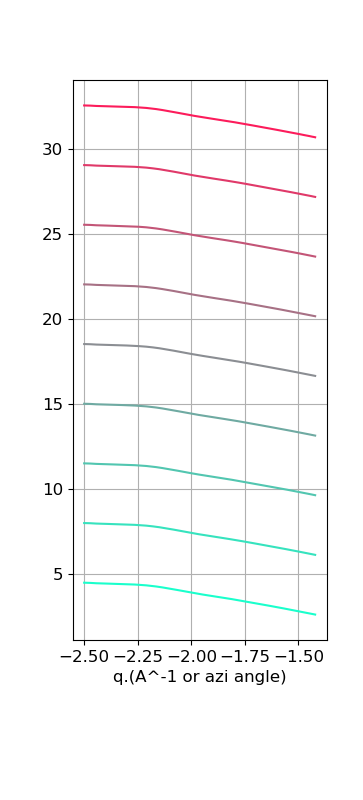

In [112]:
exp.plotWaterfall(key='circular_average', flag_log = [1,1], plot_range=np.arange(0,150))

<IPython.core.display.Javascript object>


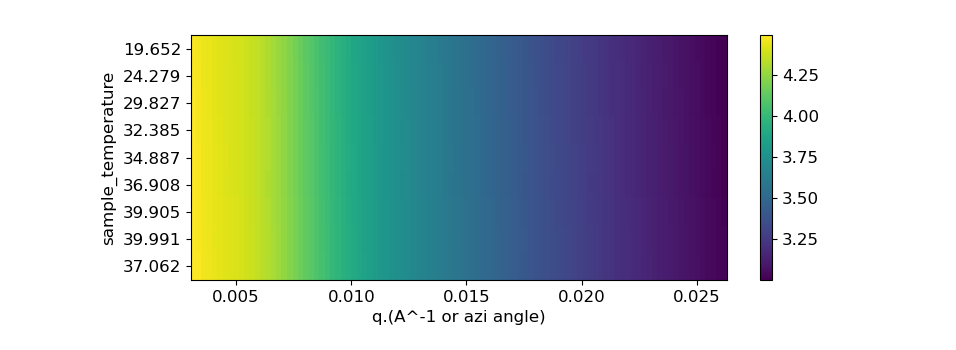

<IPython.core.display.Javascript object>


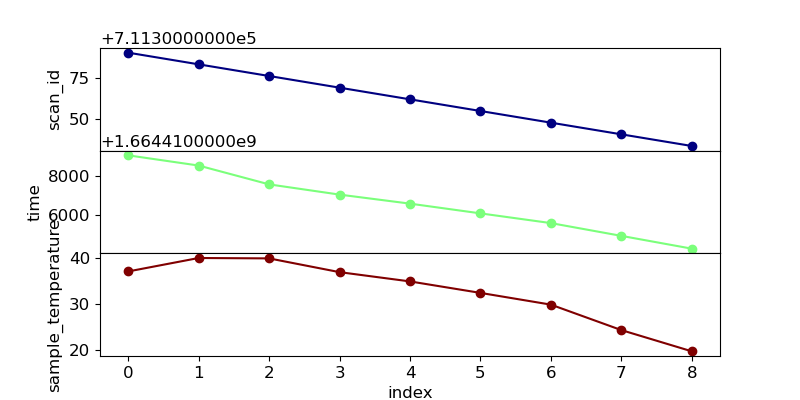

In [113]:
exp.plotHeatmap(key='circular_average', y_axes=['sample_temperature'], flag_log=1, plot_range=np.arange(0,100))

#### (Old plotting code)

Plotting 14 infiles...


<IPython.core.display.Javascript object>


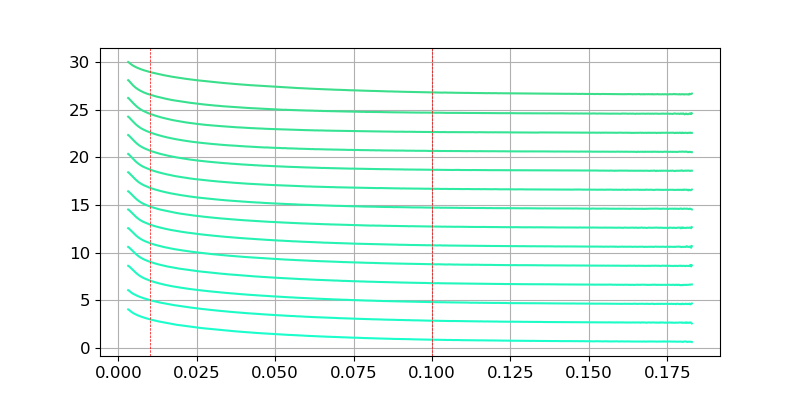

In [97]:
#patterns = ['*565096*', '*566861*', '*566879*']
patterns = ['*SM_CNC_N05*'] ### CHANGE THIS, e.g. 262223 is a unique scan id for the measurement
output_dir = EXPR_DIR+'/saxs/analysis/'


infiles = []
for pattern in patterns:
    files = glob.glob(os.path.join(output_dir+'/circular_average/', pattern+'*.dat'));  ### CHANGE THIS
    infiles.extend(files)
    
Nfile = len(infiles)
print('Plotting {} infiles...'.format(Nfile))


## Load file and Sort by scan id
temp = []
for infile in infiles:    
    #temp.append(float(infiles[j].split('/')[-1].split('_T')[1].split('_')[0][0:-1]))
    temp.append(float(infile.split('_')[-2]))
    
temp = np.array(temp)
index_arr = np.argsort(temp)


## Load and plot
plt.figure(30); plt.clf()
plt.rcParams['figure.figsize'] = [8, 5] #[height, width] of the figure

flag_log = [0, 1] # x, y 
I_list = []


for nn, idx in enumerate(index_arr):
    data = np.loadtxt(infiles[idx])
    #scan_id = float(infile.split('_')[-2])
    q = data[:,0] 
    I = data[:,2]
    NN = len(q)
    if flag_log[0]==1:
        q = np.log10(q)
    if flag_log[1]==1:
        I = np.log10(I)
        
    I_list.append(I)    
    #cc = (scan_id-5e5)
    plt.plot(q[0:NN], I[0:NN] + nn*2, color=[0.1+nn/100, 1-nn/100, 0.8-nn/50])  # y offset
    
plt.grid()


I_array = np.asarray(I_list)


QCheck = [0.01, 0.1]
for q in (QCheck):
    plt.axvline(q,linestyle='--',color='red',linewidth=0.5)

#### (Old plotting code)

<IPython.core.display.Javascript object>


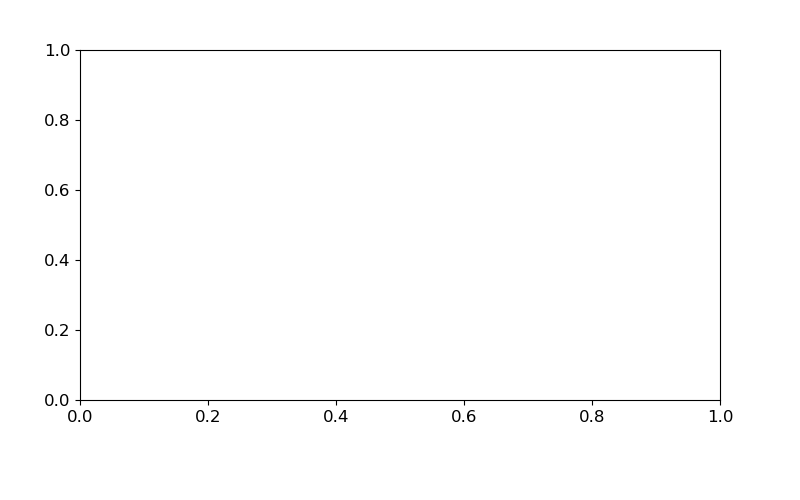

IndexError: tuple index out of range

In [44]:
fig = plt.figure(32); plt.clf()
plt.rcParams['figure.figsize'] = [8, 4] #[height, width] of the figure
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plot_buffers = plot_buffers = [0.1, 0.1, 0.2, 0.1]
left_buf, right_buf, bottom_buf, top_buf = plot_buffers
fig_width = 1.0-right_buf-left_buf
fig_height = 1.0-top_buf-bottom_buf
fig.add_axes( [left_buf, bottom_buf, fig_width, fig_height] )
    
## Plot 
y_axis = np.arange(0, I_array.shape[0])
plt.pcolormesh(q, y_axis, I_array)
 
plt.xlabel('q (A^-1)')
plt.ylabel('idx')
plt.colorbar()


if 0:
    fig = plt.figure(31); plt.clf()
    plt.imshow(I_array)
    plt.axis('auto')

if 0:
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    Y = np.arange(0, I_array.shape[0], 1)
    X, Y = np.meshgrid(q, Y)
    surf = ax.plot_surface(X, Y, I_array, rstride=1, cstride=1, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)

    

## &#9632; B.2 Plot 2D images

#### You can use this to plot 2D image: e.g. q_image or q_phi_image.

Move the cursor around to see the q or angle for peak of interest.

Can plot in log; Adjust cmap for colormap, clim for plot range.

For colormap options, see https://matplotlib.org/stable/tutorials/colors/colormaps.html

#### (Old plotting code) Load NPZ file (shows q-range for axis)

In [ ]:
pattern = '*VS*262223*'  ### CHANGE THIS
infiles = glob.glob(os.path.join(output_dir+'/q_image/', pattern+'*.npz'))  ### CHANGE THIS


infile = infiles[0] #use the first file
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(2); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 5])


#### (Old plotting code)  Load PNG file (shows pixels for axis)

In [ ]:
import imageio

pattern = ''
infiles = glob.glob(os.path.join(output_dir+'/q_image/', pattern+'*.png'))
infile = infiles[0]


img = imageio.imread(infile)
plt.figure()
plt.imshow(img)
plt.axis('off')


# &#9635; Section C


## &#9632;  C1. Comapre Experiments

To-do: load multiple experiments and compre


In [ ]:
%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis.ExpAnalysis.Experiment import *

In [ ]:
### Experiment 1
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LLoo2' ### CHANGE THIS

exp = experiment('LL', folder=EXPR_DIR,det='waxs') ### CHANGE THIS
samples = ['LL_X9']  ### CHANGE THIS, Note that this have to match the sample name 

for sample in samples:
    exp.defFiles_query(fn=sample, folder=EXPR_DIR, scanid = [510000, 520000]) 
    


In [ ]:
exp.listMetadata(verbosity=3)
exp.listMetadata(verbosity=-1) 

In [ ]:
exp.loadMetadata() 

In [ ]:
exp.loadSciAnalysisData() #load all analysis by default, or have keys=[]

In [ ]:
class compare_exp:
    
    def input_exp(exp1, exp2, exp3):
        
    def loadAnalysis(exp, params=['circular_average_fitting__temperature_peak-q0']):# load 1D curve, plot vs temperature
    
    def plot(exp1, exp2, exp3, params)
        